In [1]:
import anndata
import numpy as np
import pandas as pd
import networkx as nx
import random
import scanpy as sc
import scglue
import tqdm
from matplotlib import rcParams
from matplotlib.pyplot import rc_context

In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [3]:
concern_cell_type = ['Astro', 'Micro', 'Oligo']

In [4]:
hic_summary = pd.read_csv('/lmh_data/data/sclab/Tan2021/BandNorm/summary/Tan2021_Summary.txt', sep='\t')
hic_summary = hic_summary.set_index('cell')
hic_summary

,tissue,treatment,age,sex,father,mother,restriction enzyme,cell-type cluster
cell,,,,,,,,
cortex-p001-cb_001,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Neonatal Astrocyte
cortex-p001-cb_002,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Neonatal Neuron 1
cortex-p001-cb_003,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Neonatal Neuron 2
cortex-p001-cb_004,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Unknown
cortex-p001-cb_005,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Neonatal Neuron 2
...,...,...,...,...,...,...,...,...
hippocampus-p347-cb_188,hippocampus,control,P347,male,C57BL/6J,CAST/EiJ,MboI,Hippocampal Granule Cell
hippocampus-p347-cb_189,hippocampus,control,P347,male,C57BL/6J,CAST/EiJ,MboI,Empty Well
hippocampus-p347-cb_190,hippocampus,control,P347,male,C57BL/6J,CAST/EiJ,MboI,Empty Well


In [5]:
hic = anndata.read_h5ad("/lmh_data/data/sclab/Tan2021/scHiC.h5ad")
hic.obs.index = hic.obs.index.str.split('.').str[0].str.split('_', n=1).str[1]
hic

AnnData object with n_obs × n_vars = 1954 × 272566
    obs: 'domain'
    var: 'chrom', 'start'

In [6]:
hic.obs['cell_type'] = hic_summary.loc[hic.obs_names]['cell-type cluster']
hic.obs['cell_type'].unique()

array(['Unknown', 'Interneuron', 'Neonatal Neuron 2',
       'Oligodendrocyte Progenitor', 'Cortical L2–5 Pyramidal Cell',
       'Microglia Etc.', 'Neonatal Neuron 1', 'Adult Astrocyte',
       'Cortical L6 Pyramidal Cell', 'Hippocampal Pyramidal Cell',
       'Hippocampal Granule Cell', 'Medium Spiny Neuron',
       'Mature Oligodendrocyte', 'Neonatal Astrocyte'], dtype=object)

In [7]:
hic.obs.cell_type = hic.obs.cell_type.astype('category')
hic.obs.cell_type = hic.obs.cell_type.map({
    'Adult Astrocyte': 'Astro', 'Neonatal Astrocyte': 'Astro',
    'Microglia Etc.': 'Micro',
    'Mature Oligodendrocyte': 'Oligo', 'Oligodendrocyte Progenitor': 'Oligo',
})
hic.obs['cell_type'].unique()

array([nan, 'Oligo', 'Micro', 'Astro'], dtype=object)

In [8]:
hic = hic[hic.obs['cell_type'].isin(concern_cell_type),:]
hic

View of AnnData object with n_obs × n_vars = 533 × 272566
    obs: 'domain', 'cell_type'
    var: 'chrom', 'start'

/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
 

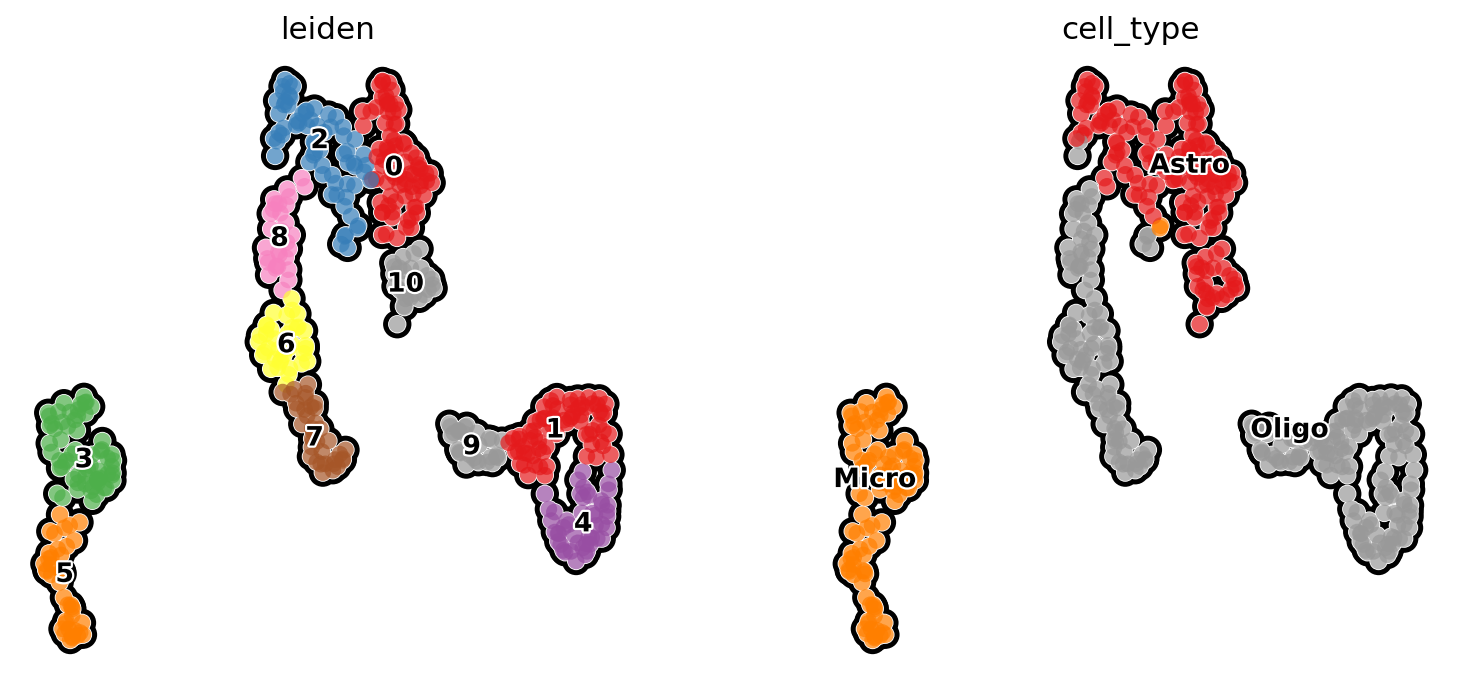

In [9]:
hic_pca = pd.read_csv('/lmh_data/data/sclab/Tan2021/BandNorm/embedding.txt', sep='\t')
hic_pca.index = hic_pca.index.str.split(".").map(lambda x: x[0])
hic_pca = hic_pca.loc[hic.obs.index]
hic.obsm["X_pca"] = hic_pca.to_numpy()

def hic_pca():
    sc.pp.neighbors(hic, use_rep="X_pca", metric="cosine")
    sc.tl.umap(hic)
    sc.tl.leiden(hic)
hic_pca()
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(hic, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

/tmp/ipykernel_259611/4123339676.py:4: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  rna.layers["counts"] = rna.X.copy()
/root/miniconda3/envs/see/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packag

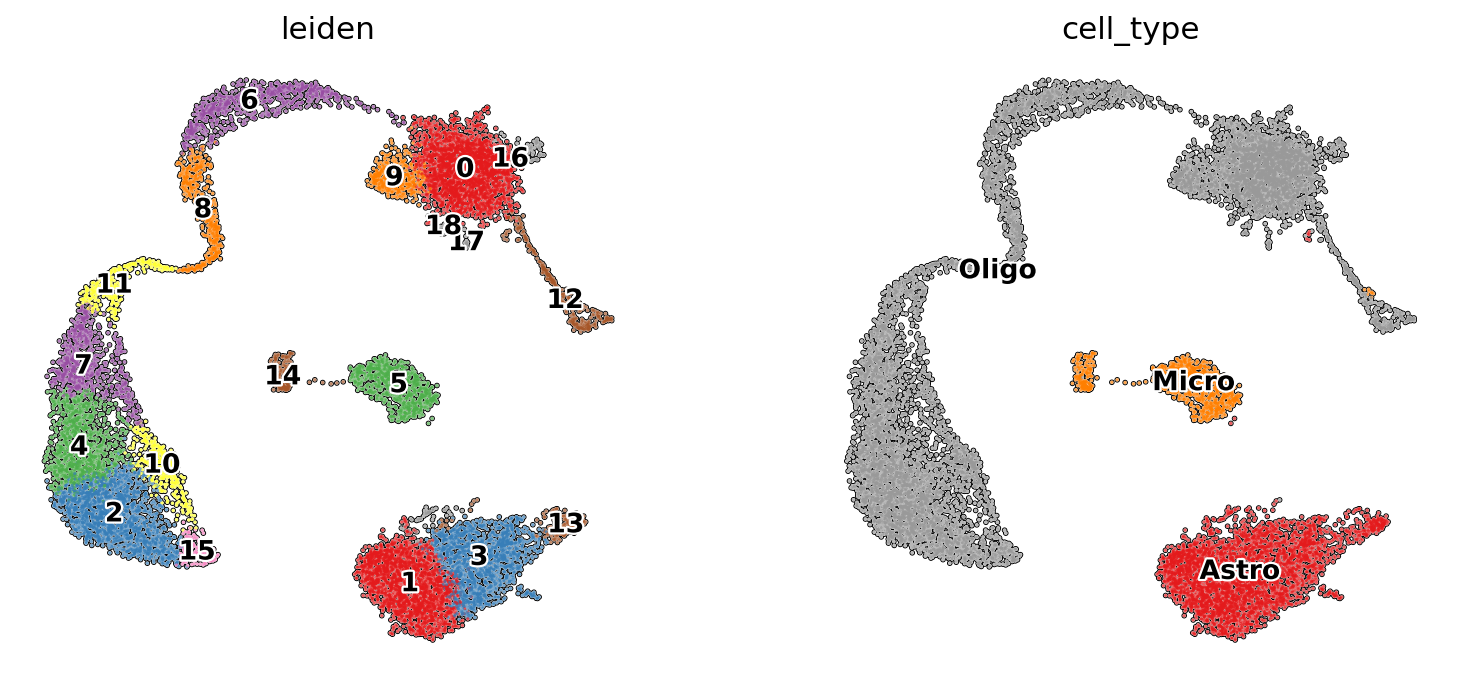

In [10]:
rna = anndata.read_h5ad("/lmh_data/data/sclab/Mouse_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Micro-PVM': 'Micro'})
rna = rna[rna.obs['cell_type'].isin(concern_cell_type),:]
rna.layers["counts"] = rna.X.copy()

scglue.data.get_gene_annotation(
    rna, gtf="/lmh_data/data/sclab/Mouse_10x/rsem_GRCm38.p3.gtf",
    gtf_by="gene_symbol"
)
rna = rna[:, rna.var.dropna(axis=0, how='all').index]

def rna_pca(rna):
    rna.X = rna.layers["counts"].copy()
    sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
    sc.pp.normalize_total(rna)
    sc.pp.log1p(rna)
    sc.pp.scale(rna)
    sc.tl.pca(rna, n_comps=100, svd_solver="auto")

    sc.pp.neighbors(rna, metric="cosine")
    sc.tl.umap(rna)
    sc.tl.leiden(rna)
rna_pca(rna)
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

In [11]:
rna = rna[rna.obs['leiden'].isin(['12', '13', '14']),:].copy()
rna

AnnData object with n_obs × n_vars = 650 × 24140
    obs: 'cell_type', 'domain', 'leiden'
    var: 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
 

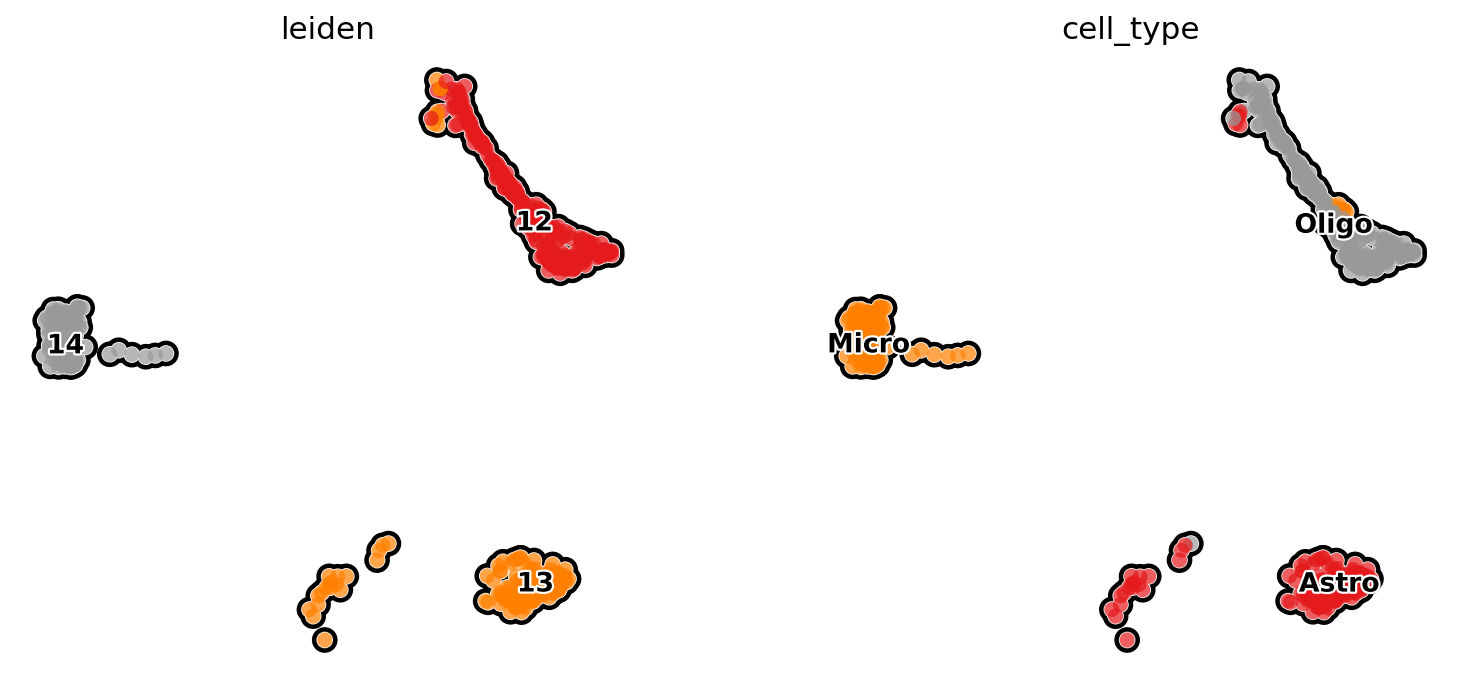

In [12]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

In [13]:
hic.var['chrom'] = [info[0] for info in hic.var_names.str.split('_')]
hic.var['chromStart'] = [int(info[1]) for info in hic.var_names.str.split('_')]
hic.var['chromEnd'] = hic.var['chromStart'] + 10000
hic.var

,chrom,start,chromStart,chromEnd
1_0,1,0,0,10000
1_10000,1,10000,10000,20000
1_20000,1,20000,20000,30000
1_30000,1,30000,30000,40000
1_40000,1,40000,40000,50000
...,...,...,...,...
Y_91700000,Y,91700000,91700000,91710000
Y_91710000,Y,91710000,91710000,91720000
Y_91720000,Y,91720000,91720000,91730000
Y_91730000,Y,91730000,91730000,91740000


In [14]:
sc.tl.rank_genes_groups(rna, 'cell_type', method='t-test')
marker_genes = pd.DataFrame(rna.uns['rank_genes_groups']['names'])[:1000]
marker_genes_index = marker_genes.values.reshape(-1)
_index = set(rna.var[rna.var['highly_variable']==True].index) & set(marker_genes_index)
rna.var['highly_variable'] = False
rna.var.loc[_index, 'highly_variable'] = True
rna.var

/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/tmp/ipykernel_259611/767983501.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  rna.var.loc[_index, 'highly_variable'] = True


,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,gene_id,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
gene_name,,,,,,,,,,,,,,,,,,,,
Xkr4,NC_000067.6,3199730.0,3671742.0,Xkr4,.,-,.,.,.,.,.,.,497097,False,NaN,NaN,NaN,1.103817,0.340549,0.501519
Rp1,NC_000067.6,4290845.0,4409266.0,Rp1,.,-,.,.,.,.,.,.,19888,False,NaN,NaN,NaN,0.902985,0.000949,0.024053
Sox17,NC_000067.6,4490927.0,4497388.0,Sox17,.,-,.,.,.,.,.,.,20671,False,1551.0,NaN,NaN,1.326367,0.000090,0.007636
Mrpl15,NC_000067.6,4773197.0,4785745.0,Mrpl15,.,-,.,.,.,.,.,.,27395,False,NaN,NaN,NaN,0.889458,0.049204,0.180763
Lypla1,NC_000067.6,4807562.0,4846737.0,Lypla1,.,+,.,.,.,.,.,.,18777,False,NaN,NaN,NaN,0.962546,0.000188,0.010863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Grk5,NC_000085.6,60889592.0,61095968.0,Grk5,.,+,.,.,.,.,.,.,14773,False,NaN,NaN,NaN,1.085032,0.077273,0.234680
Gm7102,NC_000085.6,61174685.0,61176309.0,Gm7102,.,-,.,.,.,.,.,.,633057,False,NaN,NaN,NaN,0.943305,0.000352,0.015609
Gm6020,NC_000085.6,61151863.0,61184658.0,Gm6020,.,+,.,.,.,.,.,.,547091,False,NaN,NaN,NaN,0.000000,0.000000,1.000000


In [15]:
rna.var['chrom'].unique()

['NC_000067.6', 'NC_000068.7', 'NC_000082.6', 'NC_000086.7', 'NC_000087.7', ..., 'NC_000078.6', 'NC_000081.6', 'NC_000083.6', 'NC_000084.6', 'NC_000085.6']
Length: 21
Categories (21, object): ['NC_000067.6', 'NC_000068.7', 'NC_000069.6', 'NC_000070.6', ..., 'NC_000084.6', 'NC_000085.6', 'NC_000086.7', 'NC_000087.7']

In [16]:
rna.var.chrom = rna.var.chrom.map({
    'NC_000067.6': '1', 'NC_000068.7': '2', 'NC_000069.6': '3', 'NC_000070.6': '4', 'NC_000071.6': '5',
    'NC_000072.6': '6', 'NC_000073.6': '7', 'NC_000074.6': '8', 'NC_000075.6': '9', 'NC_000076.6': '10',
    'NC_000077.6': '11', 'NC_000078.6': '12', 'NC_000079.6': '13', 'NC_000080.6': '14', 'NC_000081.6': '15',
    'NC_000082.6': '16', 'NC_000083.6': '17', 'NC_000084.6': '18', 'NC_000085.6': '19', 'NC_000086.7': 'X',
    'NC_000087.7': 'Y', 'NC_005089.1': 'MT'
})
rna.var['chrom'].unique()

['1', '2', '16', 'X', 'Y', ..., '12', '15', '17', '18', '19']
Length: 21
Categories (21, object): ['1', '2', '3', '4', ..., '18', '19', 'X', 'Y']

In [17]:
import collections
import pybedtools

from pybedtools.cbedtools import Interval
from scglue.check import check_deps
from scglue.genomics import Bed
from tqdm.auto import tqdm
from typing import Any, Callable, Mapping, Optional, Union

def interval_dist(x: Interval, y: Interval) -> int:
    r"""
    Compute distance and relative position between two bed intervals

    Parameters
    ----------
    x
        First interval
    y
        Second interval

    Returns
    -------
    dist
        Signed distance between ``x`` and ``y``
    """
    if x.chrom != y.chrom:
        return np.inf * (-1 if x.chrom < y.chrom else 1)

    _start1, _end1 = (x.stop, x.start) if x.strand == '-' else (x.start, x.stop)
    _start2, _end2 = (y.stop, y.start) if y.strand == '-' else (y.start, y.stop)
    
    d = _start1-_start2
#     d = min(abs(_start1-_start2), abs(_end1-_start2))
#     if abs(d) <= 10000:
#         d = 0

    x_range = set([i for i in range(int(x.start/10000)*10000, int(x.end/10000)*10000+10000, 10000)])
    y_range = set([i for i in range(y.start, y.end+10000, 10000)])
    if x_range&y_range:
        d = 0

    return d
        
#     if x.start < y.stop and y.start < x.stop:
#         return 0
#     if x.stop <= y.start:
#         return x.stop - y.start - 1
#     if y.stop <= x.start:
#         return x.start - y.stop + 1

def window_graph(
        left: Union[Bed, str], right: Union[Bed, str], window_size: int,
        left_sorted: bool = False, right_sorted: bool = False,
        attr_fn: Optional[Callable[[Interval, Interval, float], Mapping[str, Any]]] = None
) -> nx.MultiDiGraph:
    r"""
    Construct a window graph between two sets of genomic features, where
    features pairs within a window size are connected.

    Parameters
    ----------
    left
        First feature set, either a :class:`Bed` object or path to a bed file
    right
        Second feature set, either a :class:`Bed` object or path to a bed file
    window_size
        Window size (in bp)
    left_sorted
        Whether ``left`` is already sorted
    right_sorted
        Whether ``right`` is already sorted
    attr_fn
        Function to compute edge attributes for connected features,
        should accept the following three positional arguments:

        - l: left interval
        - r: right interval
        - d: signed distance between the intervals

        By default no edge attribute is created.

    Returns
    -------
    graph
        Window graph
    """
    if isinstance(left, Bed):
        pbar_total = len(left)
        left = left.to_bedtool()
    else:
        pbar_total = None
        left = pybedtools.BedTool(left)
    if not left_sorted:
        left = left.sort(stream=True)
    left = iter(left)  # Resumable iterator
    if isinstance(right, Bed):
        right = right.to_bedtool()
    else:
        right = pybedtools.BedTool(right)
    if not right_sorted:
        right = right.sort(stream=True)
    right = iter(right)  # Resumable iterator

    attr_fn = attr_fn or (lambda l, r, d: {})
    if pbar_total is not None:
        left = tqdm(left, total=pbar_total, desc="window_graph")
    graph = nx.MultiDiGraph()
    window = collections.OrderedDict()  # Used as ordered set
    searched_chrom = set()
    for l in left:
        searched_chrom.add(l.chrom)
        for r in list(window.keys()):  # Allow remove during iteration
            if r.chrom != l.chrom and r.chrom in searched_chrom:
                del window[r]
                continue
            d = interval_dist(l, r)
            if -window_size <= d <= window_size:
                graph.add_edge(l.name, r.name, **attr_fn(l, r, d))
        else:
            for r in right:  # Resume from last break
                d = interval_dist(l, r)
                window[r] = None
                if np.isinf(d):
                    break
                if -window_size <= d <= window_size:
                    graph.add_edge(l.name, r.name, **attr_fn(l, r, d))
    pybedtools.cleanup()
    return graph

import itertools
import networkx as nx

rna_bed = scglue.genomics.Bed(rna.var.assign(name=rna.var_names))
hic_bed = scglue.genomics.Bed(hic.var.assign(name=hic.var_names))

rna_bed = rna_bed.expand(5000, 0)

def _dist_power_decay(x: int) -> float:
    return ((x + 10000) / 10000) ** (-0.75)
graph = window_graph(
    rna_bed, hic_bed, window_size=10000,
    attr_fn=lambda l, r, d, s=1: {
        "dist": abs(d), "weight": _dist_power_decay(abs(d)), "sign": s
    }
)

rgraph = graph.reverse()
nx.set_edge_attributes(graph, "fwd", name="type")
nx.set_edge_attributes(rgraph, "rev", name="type")
graph = scglue.graph.compose_multigraph(graph, rgraph)

hvg_reachable = scglue.graph.reachable_vertices(graph, rna.var.query("highly_variable").index)
hic.var["highly_variable"] = [
    item in hvg_reachable for item in hic.var_names
]

all_features = set(itertools.chain.from_iterable(
    map(lambda x: x.var_names, [rna, hic])
))
for item in all_features:
    graph.add_edge(item, item, weight=1.0, sign=1, type="loop")

window_graph:   0%|          | 0/24140 [00:00<?, ?it/s]

In [18]:
hic.var.query("highly_variable").index

Index(['1_4760000', '1_4770000', '1_4780000', '1_4790000', '1_4800000',
       '1_4810000', '1_4820000', '1_4830000', '1_4840000', '1_4850000',
       ...
       'X_143850000', 'X_143860000', 'X_143870000', 'X_143880000',
       'X_143890000', 'X_143900000', 'X_143910000', 'X_143920000',
       'X_143930000', 'X_143940000'],
      dtype='object', length=27838)

In [19]:
graph.number_of_nodes(), graph.number_of_edges()

(296706, 657992)

In [20]:
all(graph.has_node(gene) for gene in rna.var_names), \
all(graph.has_node(peak) for peak in hic.var_names), \
all(graph.has_edge(gene, gene) for gene in rna.var_names), \
all(graph.has_edge(peak, peak) for peak in hic.var_names), \
all(graph.has_edge(j, i) for i, j, _ in graph.edges)

(True, True, True, True, True)

In [21]:
hic.var.head()

,chrom,start,chromStart,chromEnd,highly_variable
1_0,1,0,0,10000,False
1_10000,1,10000,10000,20000,False
1_20000,1,20000,20000,30000,False
1_30000,1,30000,30000,40000,False
1_40000,1,40000,40000,50000,False


In [22]:
rna.write("/lmh_data/data/sclab/sclab/mouse/rna_preprocessed.h5ad", compression="gzip")
hic.write("/lmh_data/data/sclab/sclab/mouse/hic_preprocessed.h5ad", compression="gzip")
nx.write_graphml(graph, "/lmh_data/data/sclab/sclab/mouse/prior.graphml.gz")